In [1]:
require(tidyverse)
require(party)
require(mgcv)
require(lattice)
require(languageR)
require(itsadug)
require(repr)

Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.1     √ purrr   0.3.4
√ tibble  3.0.1     √ dplyr   1.0.0
√ tidyr   1.1.0     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: party

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: 'strucchange'


The following object is masked from 'package:stringr':

    boundary


Loading required package: mgcv

Loading required package: nlme


Attaching pac

## CLP data

In [69]:
cent = read_csv("../data/sense_graph/sense_graph_centrality.csv")
msyl = read_csv("../data/sense_graph/sense_graph_monosyll.csv")
bsyl = read_csv("../data/sense_graph/sense_graph_bisyll.csv")

Parsed with column specification:
cols(
  sense = col_character(),
  degree = col_double(),
  closeness = col_double(),
  betweenness = col_double()
)

Parsed with column specification:
cols(
  mw = col_character(),
  mw_nV = col_double(),
  mw_nE = col_double(),
  mw_weightD = col_double(),
  mw_D = col_double()
)

Parsed with column specification:
cols(
  word = col_character(),
  word_sense = col_character(),
  c1_sense = col_character(),
  c2_sense = col_character(),
  c1_pathlen = col_double(),
  c2_pathlen = col_double(),
  c1w_dist = col_double(),
  c2w_dist = col_double()
)



In [70]:
clp = read_csv("../data/CLP_sense_indices_2char.csv")
clp$C1 = substr(clp$Word_Trad, 1, 1)
clp$C2 = substr(clp$Word_Trad, 2, 2)
clp$log_freq_W = log(clp$`SS&M-W`)
clp$log_freq_C1 = log(clp$`SS&M-C1`)
clp$log_freq_C2 = log(clp$`SS&M-C2`)
clp$RTinv = -1000/clp$RT
clp$sf_rmax_W = log((clp$sfreq_max_W+1) / (clp$sfreq_sum_W+1))
clp$sf_rmax_C1 = log((clp$sfreq_max_C1+1) / (clp$sfreq_sum_C1+1))
clp$sf_rmax_C2 = log((clp$sfreq_max_C2+1) / (clp$sfreq_sum_C2+1))
clp = merge(clp, msyl, by.x="C1", by.y="mw")
clp = merge(clp, msyl, by.x="C2", by.y="mw", suffixes=c("_C1", "_C2"))
c2_mw_idx = grep("^mw_", names(clp))
clp = merge(clp, bsyl, by.x="Word_Trad", by.y="word")
clp$rVE_C1 = log(clp$mw_nV_C1)-log(clp$mw_nE_C1)
clp$rVE_C2 = log(clp$mw_nV_C2)-log(clp$mw_nE_C2)

Parsed with column specification:
cols(
  .default = col_double(),
  Word_Trad = col_character(),
  Word_Sim = col_character(),
  C1 = col_character(),
  C2 = col_character()
)

See spec(...) for full column specifications.



In [71]:
dim(clp)

[1] 3056   87

In [72]:
names(clp)

[1] "Word_Trad"           "C2"                  "C1"                 
 [4] "Word_Sim"            "Ntrials"             "Acc"                
 [7] "RT"                  "RT-SE"               "RT-SD"              
[10] "zRT"                 "Stroke-1"            "Stroke-2"           
[13] "C&B-Subtitle-raw-C1" "C&B-Subtitle-raw-C2" "C&B-Subtitle-CD-C1" 
[16] "C&B-Subtitle-CD-C2"  "SS&M-C1"             "SS&M-C2"            
[19] "Da-Modern-C1"        "Da-Modern-C2"        "Google-freq-C1"     
[22] "Google-freq-C2"      "C&B-Subtitle-raw-W"  "C&B-Subtitle-CD-W"  
[25] "SS&M-W"              "Da-News-W"           "Da-Fiction-W"       
[28] "Google-freq-W"       "ST-C1"               "ST-C2"              
[31] "n_sense_W"           "log_n_sense_W"       "n_tagged_W"         
[34] "sfreq_sum_W"         "sfreq_max_W"         "sfreq_std_W"        
[37] "sfreq_ent_W"         "sfreq_ent_norm_W"    "vol_raw_W"          
[40] "vol_cen_W"           "vol_cennorm_W"       "n_sense_C1"         
[43] "log_n_sense_C1"      "n_tagged_C1"         "sfreq_sum_C1"       
[46] "sfreq_max_C1"        "sfreq_std_C1"        "sfreq_ent_C1"       
[49] "sfreq_ent_norm_C1"   "vol_raw_C1"          "vol_cen_C1"         
[52] "vol_cennorm_C1"      "n_sense_C2"          "log_n_sense_C2"     
[55] "n_tagged_C2"         "sfreq_sum_C2"        "sfreq_max_C2"       
[58] "sfreq_std_C2"        "sfreq_ent_C2"        "sfreq_ent_norm_C2"  
[61] "vol_raw_C2"          "vol_cen_C2"          "vol_cennorm_C2"     
[64] "log_freq_W"          "log_freq_C1"         "log_freq_C2"        
[67] "RTinv"               "sf_rmax_W"           "sf_rmax_C1"         
[70] "sf_rmax_C2"          "mw_nV_C1"            "mw_nE_C1"           
[73] "mw_weightD_C1"       "mw_D_C1"             "mw_nV_C2"           
[76] "mw_nE_C2"            "mw_weightD_C2"       "mw_D_C2"            
[79] "word_sense"          "c1_sense"            "c2_sense"           
[82] "c1_pathlen"          "c2_pathlen"          "c1w_dist"           
[85] "c2w_dist"            "rVE_C1"              "rVE_C2"

In [73]:
## helper function to plot interaction
popt = function(w, h, r=200) { options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r) }
plot_int = function(model, idx, x, y){
    popt(12, 6)
    par(mfrow=c(1,2))
    plot(model, select=idx)
    vis.gam(model, view=c(x, y), plot.type="contour", color="topo", too.far=0.1)
}

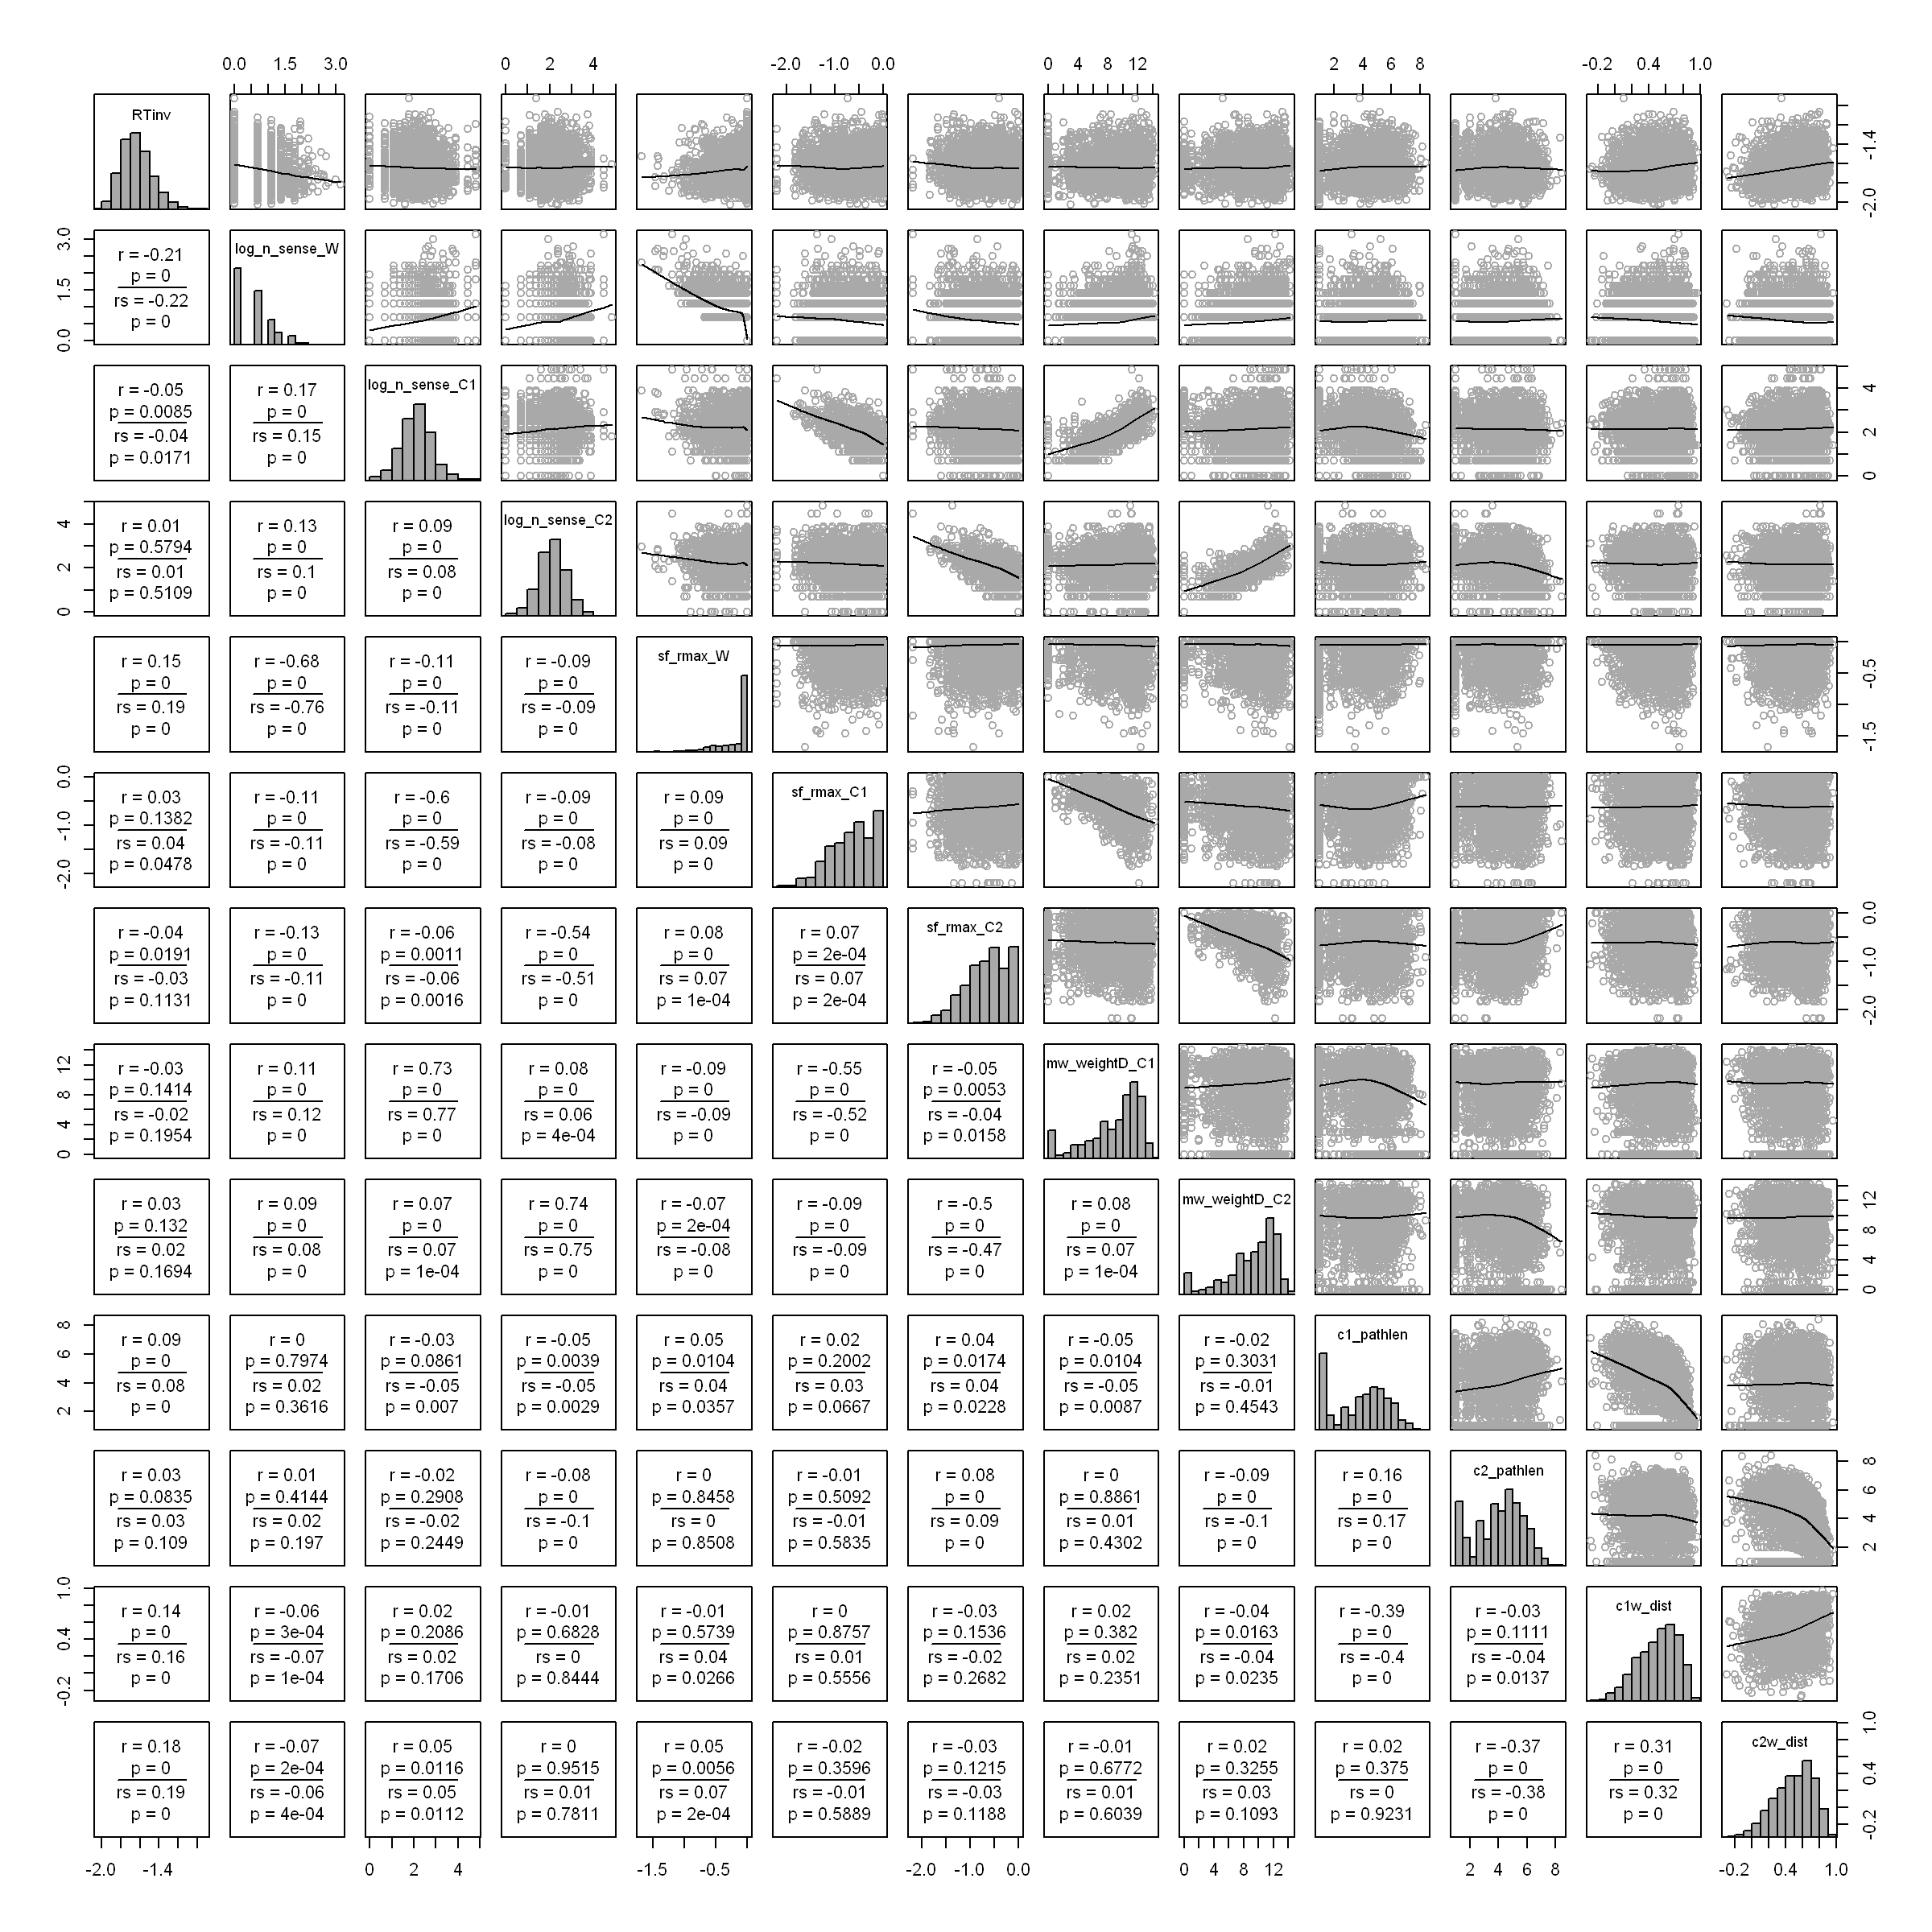

In [74]:
clp_variables = c("RTinv", 
                  "log_n_sense_W", "log_n_sense_C1", "log_n_sense_C2",
                  "sf_rmax_W", "sf_rmax_C1", "sf_rmax_C2", 
                  "mw_weightD_C1", "mw_weightD_C2", "c1_pathlen", "c2_pathlen",
                  "c1w_dist", "c2w_dist")
options(repr.plot.width=12, repr.plot.height=12)

pairscor.fnc(clp[,c(clp_variables)])

## Variable importance

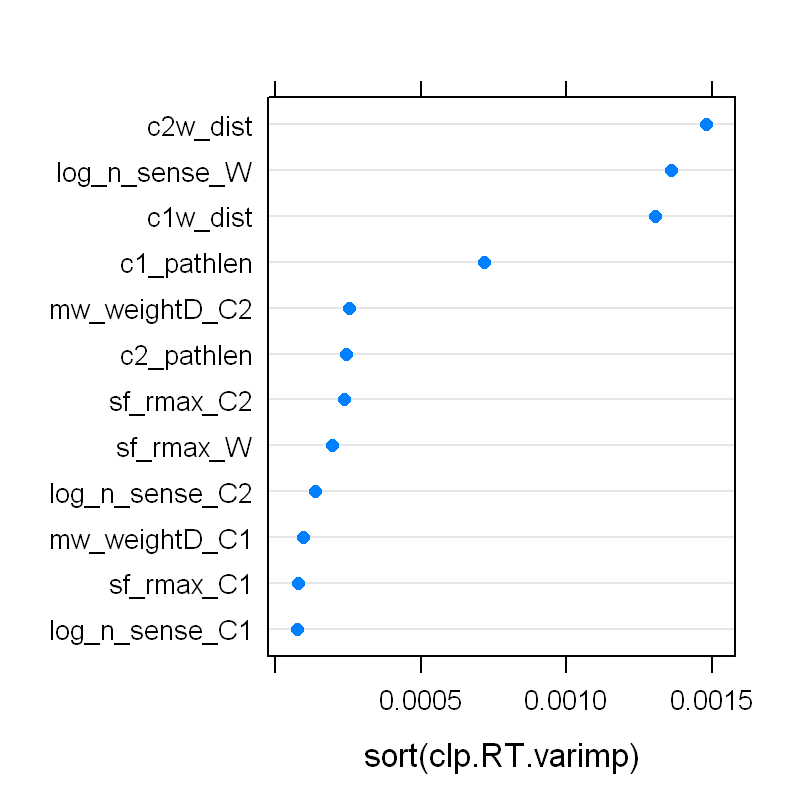

In [36]:
popt(4,4,200)
clp_variables = c("RTinv", 
                  "log_n_sense_W", "log_n_sense_C1", "log_n_sense_C2",
                  "sf_rmax_W", "sf_rmax_C1", "sf_rmax_C2", 
                  "mw_weightD_C1", "mw_weightD_C2",
                  "c1_pathlen", "c2_pathlen",
                  "c1w_dist", "c2w_dist")
clp.RT.cf <- cforest(RTinv ~ ., data=clp[,clp_variables])
clp.RT.varimp = varimp(clp.RT.cf)
options(repr.plot.width=4, repr.plot.height=4)
dotplot(sort(clp.RT.varimp), main=list(cex=2))

In [37]:
m.0 = bam(RTinv~s(log_freq_W)+s(log_freq_C1)+s(log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)
          +s(sf_rmax_C1)+s(sf_rmax_C2)
          +s(mw_weightD_C1)+s(mw_weightD_C2)
          +s(c1w_dist)+s(c2w_dist), data=clp)

In [38]:
summary(m.0)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    s(mw_weightD_C1) + s(mw_weightD_C2) + s(c1w_dist) + s(c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002343  -698.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                    edf Ref.df       F  p-value    
s(log_freq_W)     3.628  4.606 232.744  < 2e-16 ***
s(log_freq_C1)    2.845  3.625  17.592  < 2e-16 ***
s(log_freq_C2)    4.517  5.627  16.695  < 2e-16 ***
s(log_n_sense_W)  1.527  1.873   7.612  0.00240 ** 
s(log_n_sense_C1) 1.000  1.000  10.492  0.00121 ** 
s(log_n_sense_C2) 3.011  3.825   3.090  0.01653 *  
s(sf_rmax_C1)     2.747  3.467   2.732  0.03504 *  
s(sf_rmax_C2)     5.351  6.521   5.432 7.76e-06 ***
s(mw_weight

In [43]:
m.1 = bam(RTinv~s(log_freq_W)+s(log_freq_C1)+s(log_freq_C2)
          +s(log_n_sense_W)+s(log_n_sense_C1)+s(log_n_sense_C2)          
          +s(sf_rmax_C1)+s(sf_rmax_C2)
          +s(mw_weightD_C1)+s(mw_weightD_C2)
          +te(c1w_dist, c2w_dist), data=clp)

In [44]:
summary(m.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    s(mw_weightD_C1) + s(mw_weightD_C2) + te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002339  -700.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                        edf Ref.df       F  p-value    
s(log_freq_W)         3.559  4.525 235.204  < 2e-16 ***
s(log_freq_C1)        2.702  3.449  16.539  < 2e-16 ***
s(log_freq_C2)        4.554  5.669  15.355  < 2e-16 ***
s(log_n_sense_W)      1.472  1.795   7.508  0.00357 ** 
s(log_n_sense_C1)     1.000  1.000   9.897  0.00167 ** 
s(log_n_sense_C2)     3.102  3.933   3.016  0.01753 *  
s(sf_rmax_C1)         2.809  3.544   2.847  0.02856 *  
s(sf_rmax_C2)         5.264  6.425

In [34]:
compareML(m.0, m.1)

m.0: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    s(c1w_dist) + s(c2w_dist)

m.1: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df   p.value Sig.
1   m.0 -1829.679  21                                
2   m.1 -1837.810  22      8.132 1.000 5.511e-05  ***

AIC difference: 8.57, model m.1 has lower AIC.



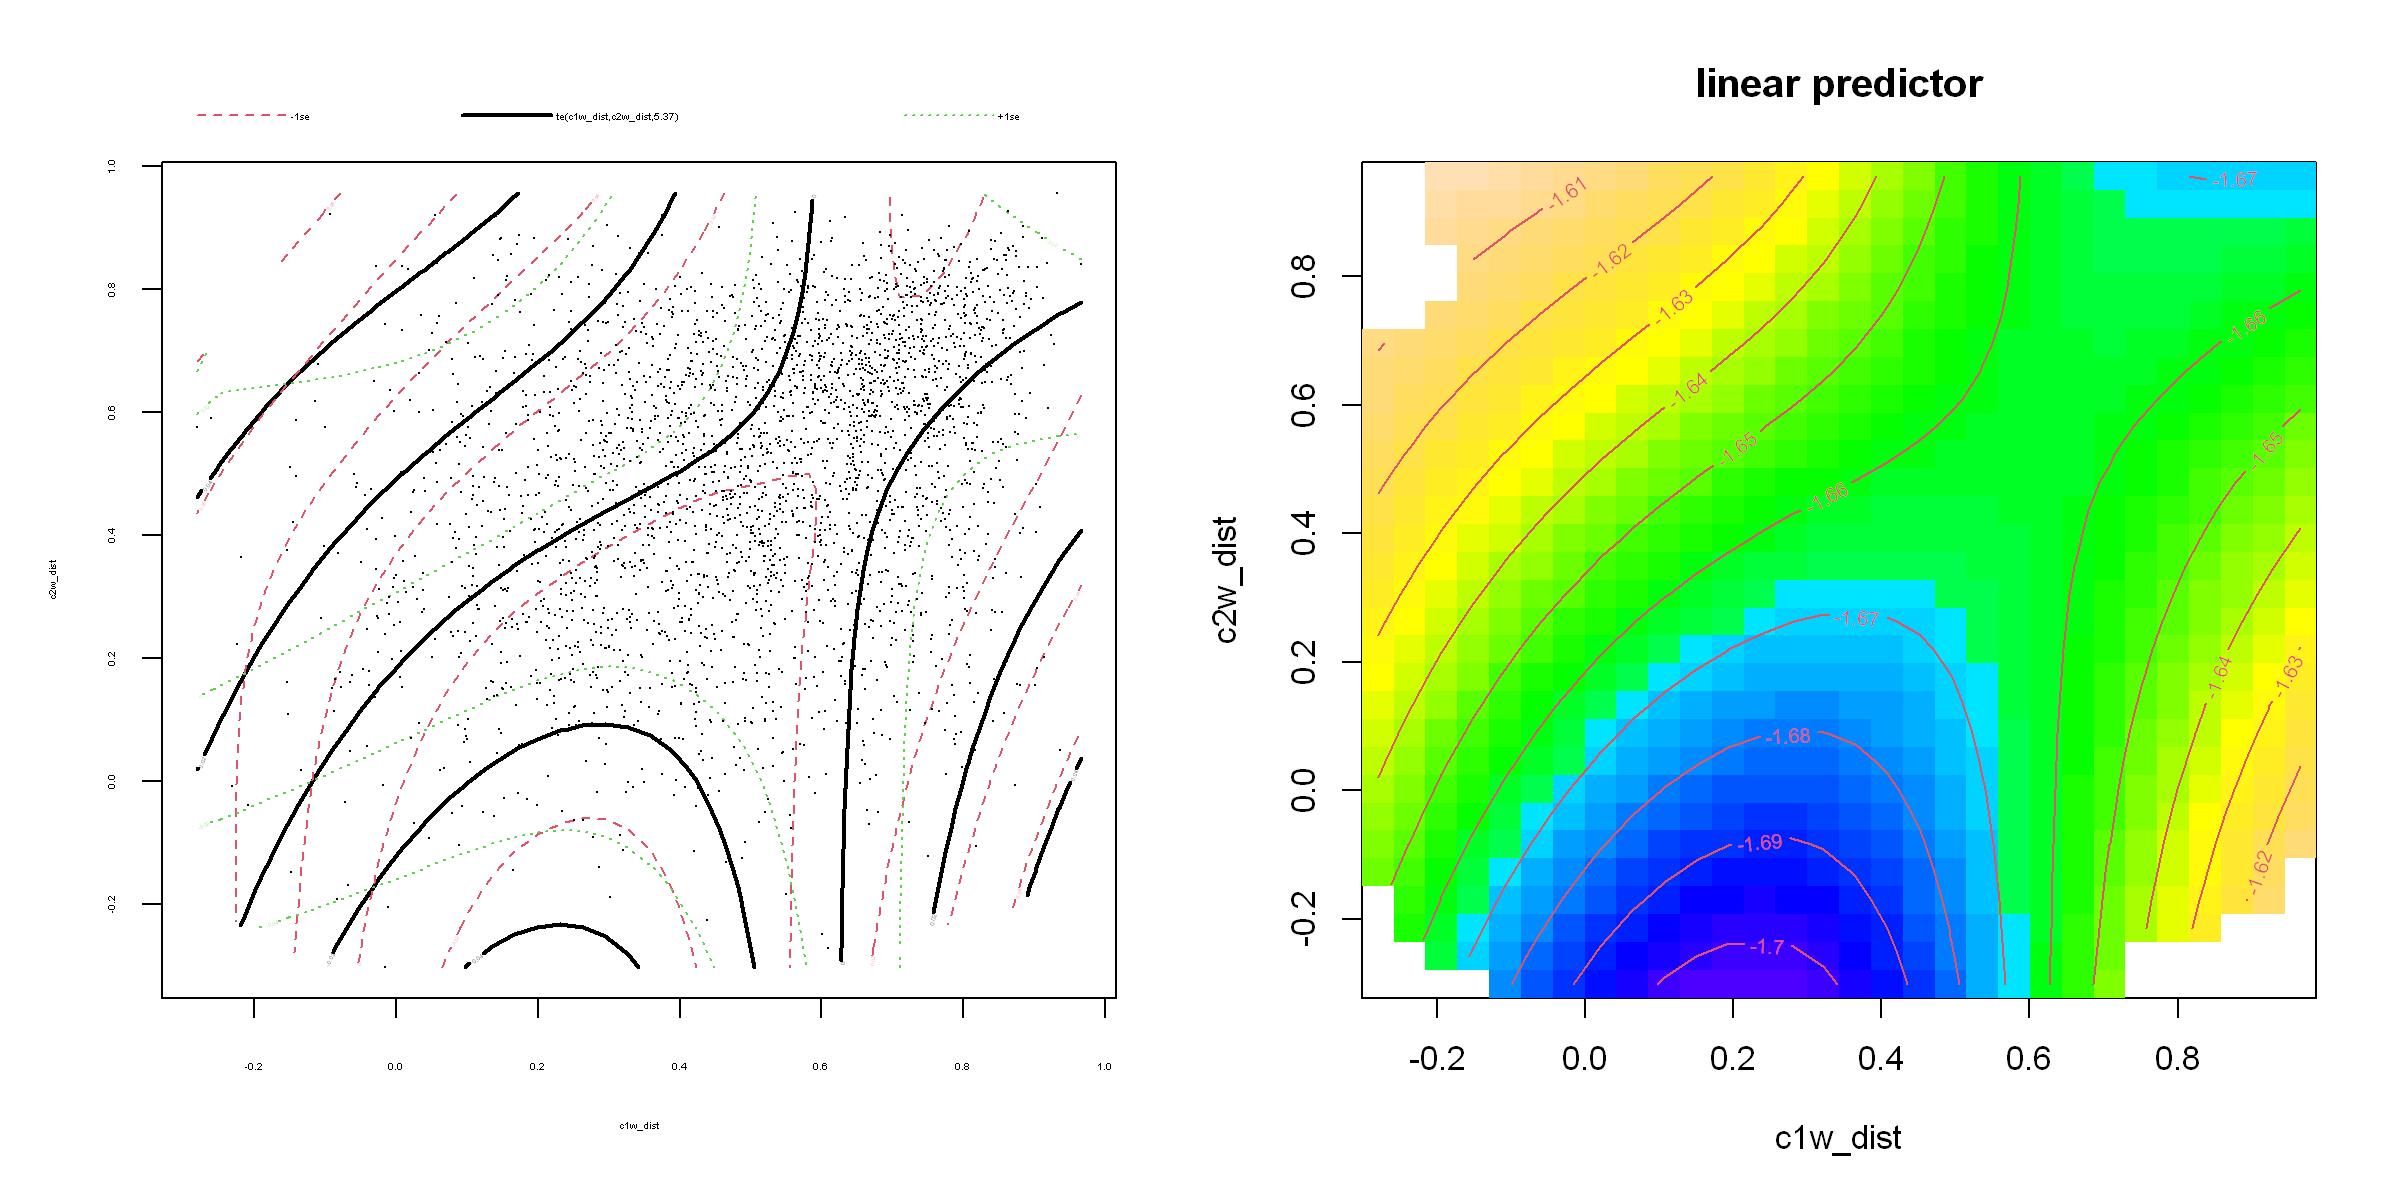

In [35]:
plot_int(m.1, 9, "c1w_dist", "c2w_dist")

In [52]:
m.2 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)
          +s(log_n_sense_C1) + s(log_n_sense_C2)          
          +s(sf_rmax_C1) + s(sf_rmax_C2)
          +te(c1w_dist, c2w_dist), data=clp)

In [53]:
summary(m.2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002338  -700.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                              edf Ref.df       F  p-value    
s(log_freq_W)               3.619  4.596 234.277  < 2e-16 ***
te(log_freq_C1,log_freq_C2) 9.800 12.347  15.184  < 2e-16 ***
s(log_n_sense_W)            1.274  1.495   8.778  0.00260 ** 
s(log_n_sense_C1)           1.000  1.000   8.037  0.00461 ** 
s(log_n_sense_C2)           2.583  3.302   2.454  0.05308 .  
s(sf_rmax_C1)               2.597  3.278   2.538  0.04917 *  
s(sf_rmax_C2)               5.040  6.185   5.730 4.76e-06 ***
te(c1w_dist,c2w_dist)      

In [56]:
compareML(m.1, m.2)

m.1: RTinv ~ s(log_freq_W) + s(log_freq_C1) + s(log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    s(mw_weightD_C1) + s(mw_weightD_C2) + te(c1w_dist, c2w_dist)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Model m.2 preferred: lower fREML score (14.375), and lower df (3.000).
-----
  Model     Score Edf Difference    Df
1   m.1 -1831.256  26                 
2   m.2 -1845.631  23    -14.375 3.000

AIC difference: 2.67, model m.2 has lower AIC.



In [57]:
m.3 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)
          +te(log_n_sense_C1, log_n_sense_C2)          
          +s(sf_rmax_C1) + s(sf_rmax_C2)
          +te(c1w_dist, c2w_dist), data=clp)

In [58]:
summary(m.3)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    te(log_n_sense_C1, log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002339  -700.1   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                                    edf Ref.df       F  p-value    
s(log_freq_W)                     3.686  4.677 230.837  < 2e-16 ***
te(log_freq_C1,log_freq_C2)       9.758 12.279  15.157  < 2e-16 ***
s(log_n_sense_W)                  1.093  1.180  10.690 0.000992 ***
te(log_n_sense_C1,log_n_sense_C2) 3.945  4.495   4.030 0.001928 ** 
s(sf_rmax_C1)                     2.554  3.226   2.373 0.062985 .  
s(sf_rmax_C2)                     4.982  6.122   5.722 4.94e-06 ***
te(c1w_dist,c2w_dist)             5.530  6.498   2

In [59]:
compareML(m.2, m.3)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

m.3: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    te(log_n_sense_C1, log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1   m.2 -1845.631  23                              
2   m.3 -1850.436  24      4.805 1.000   0.002  ** 

AIC difference: -0.98, model m.2 has lower AIC.



Warning message in compareML(m.2, m.3):
"Only small difference in fREML...
"


In [60]:
m.31 = bam(RTinv~s(log_freq_W)
          +te(log_freq_C1, log_freq_C2)
          +s(log_n_sense_W)
          +s(log_n_sense_C1)+s(log_n_sense_C2)          
          +te(sf_rmax_C1, sf_rmax_C2)
          +te(c1w_dist, c2w_dist), data=clp)

In [61]:
summary(m.31)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + te(sf_rmax_C1, sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.637403   0.002341  -699.5   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                              edf Ref.df       F  p-value    
s(log_freq_W)               3.615  4.592 235.590  < 2e-16 ***
te(log_freq_C1,log_freq_C2) 9.566 12.096  15.453  < 2e-16 ***
s(log_n_sense_W)            1.119  1.228  10.402  0.00113 ** 
s(log_n_sense_C1)           1.000  1.000   8.463  0.00365 ** 
s(log_n_sense_C2)           2.080  2.670   2.704  0.05495 .  
te(sf_rmax_C1,sf_rmax_C2)   8.286 10.753   3.809 2.39e-05 ***
te(c1w_dist,c2w_dist)       5.592  6.565   2.912  0.00796 ** 
---
Signif. codes:  0 '***' 0.

In [63]:
compareML(m.2, m.31)

m.2: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + s(sf_rmax_C1) + s(sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

m.31: RTinv ~ s(log_freq_W) + te(log_freq_C1, log_freq_C2) + s(log_n_sense_W) + 
    s(log_n_sense_C1) + s(log_n_sense_C2) + te(sf_rmax_C1, sf_rmax_C2) + 
    te(c1w_dist, c2w_dist)

Chi-square test of fREML scores
-----
  Model     Score Edf Difference    Df p.value Sig.
1   m.2 -1845.631  23                              
2  m.31 -1849.126  24      3.496 1.000   0.008  ** 

AIC difference: -7.79, model m.2 has lower AIC.



Warning message in compareML(m.2, m.31):
"Only small difference in fREML...
"


## Visualization

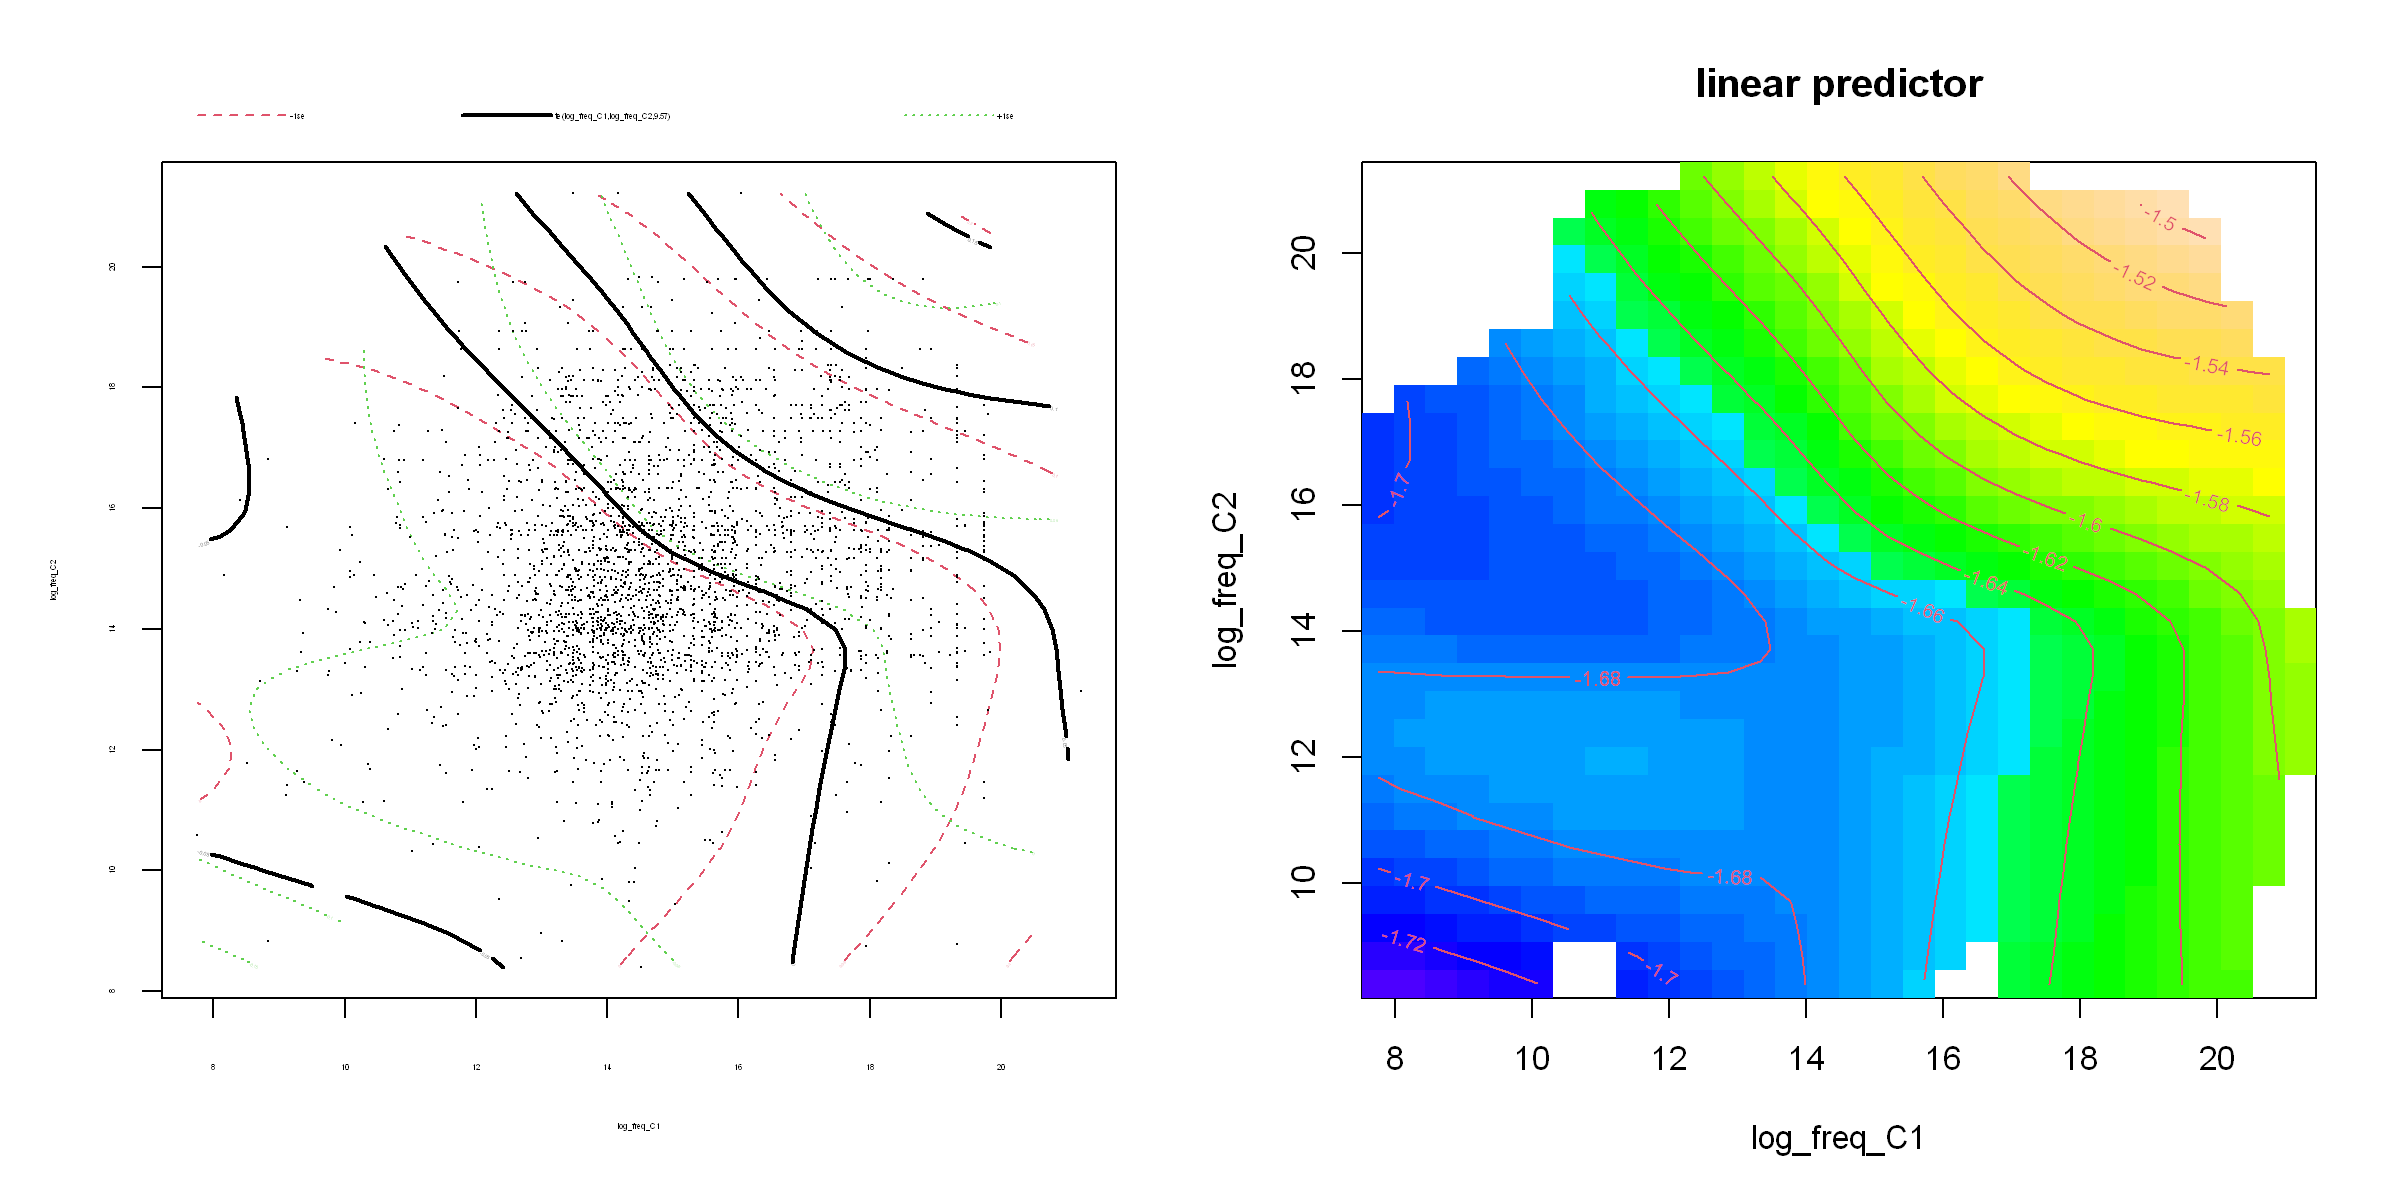

In [65]:
popt(8, 4, 200)
plot_int(m.31, 2, "log_freq_C1", "log_freq_C2")

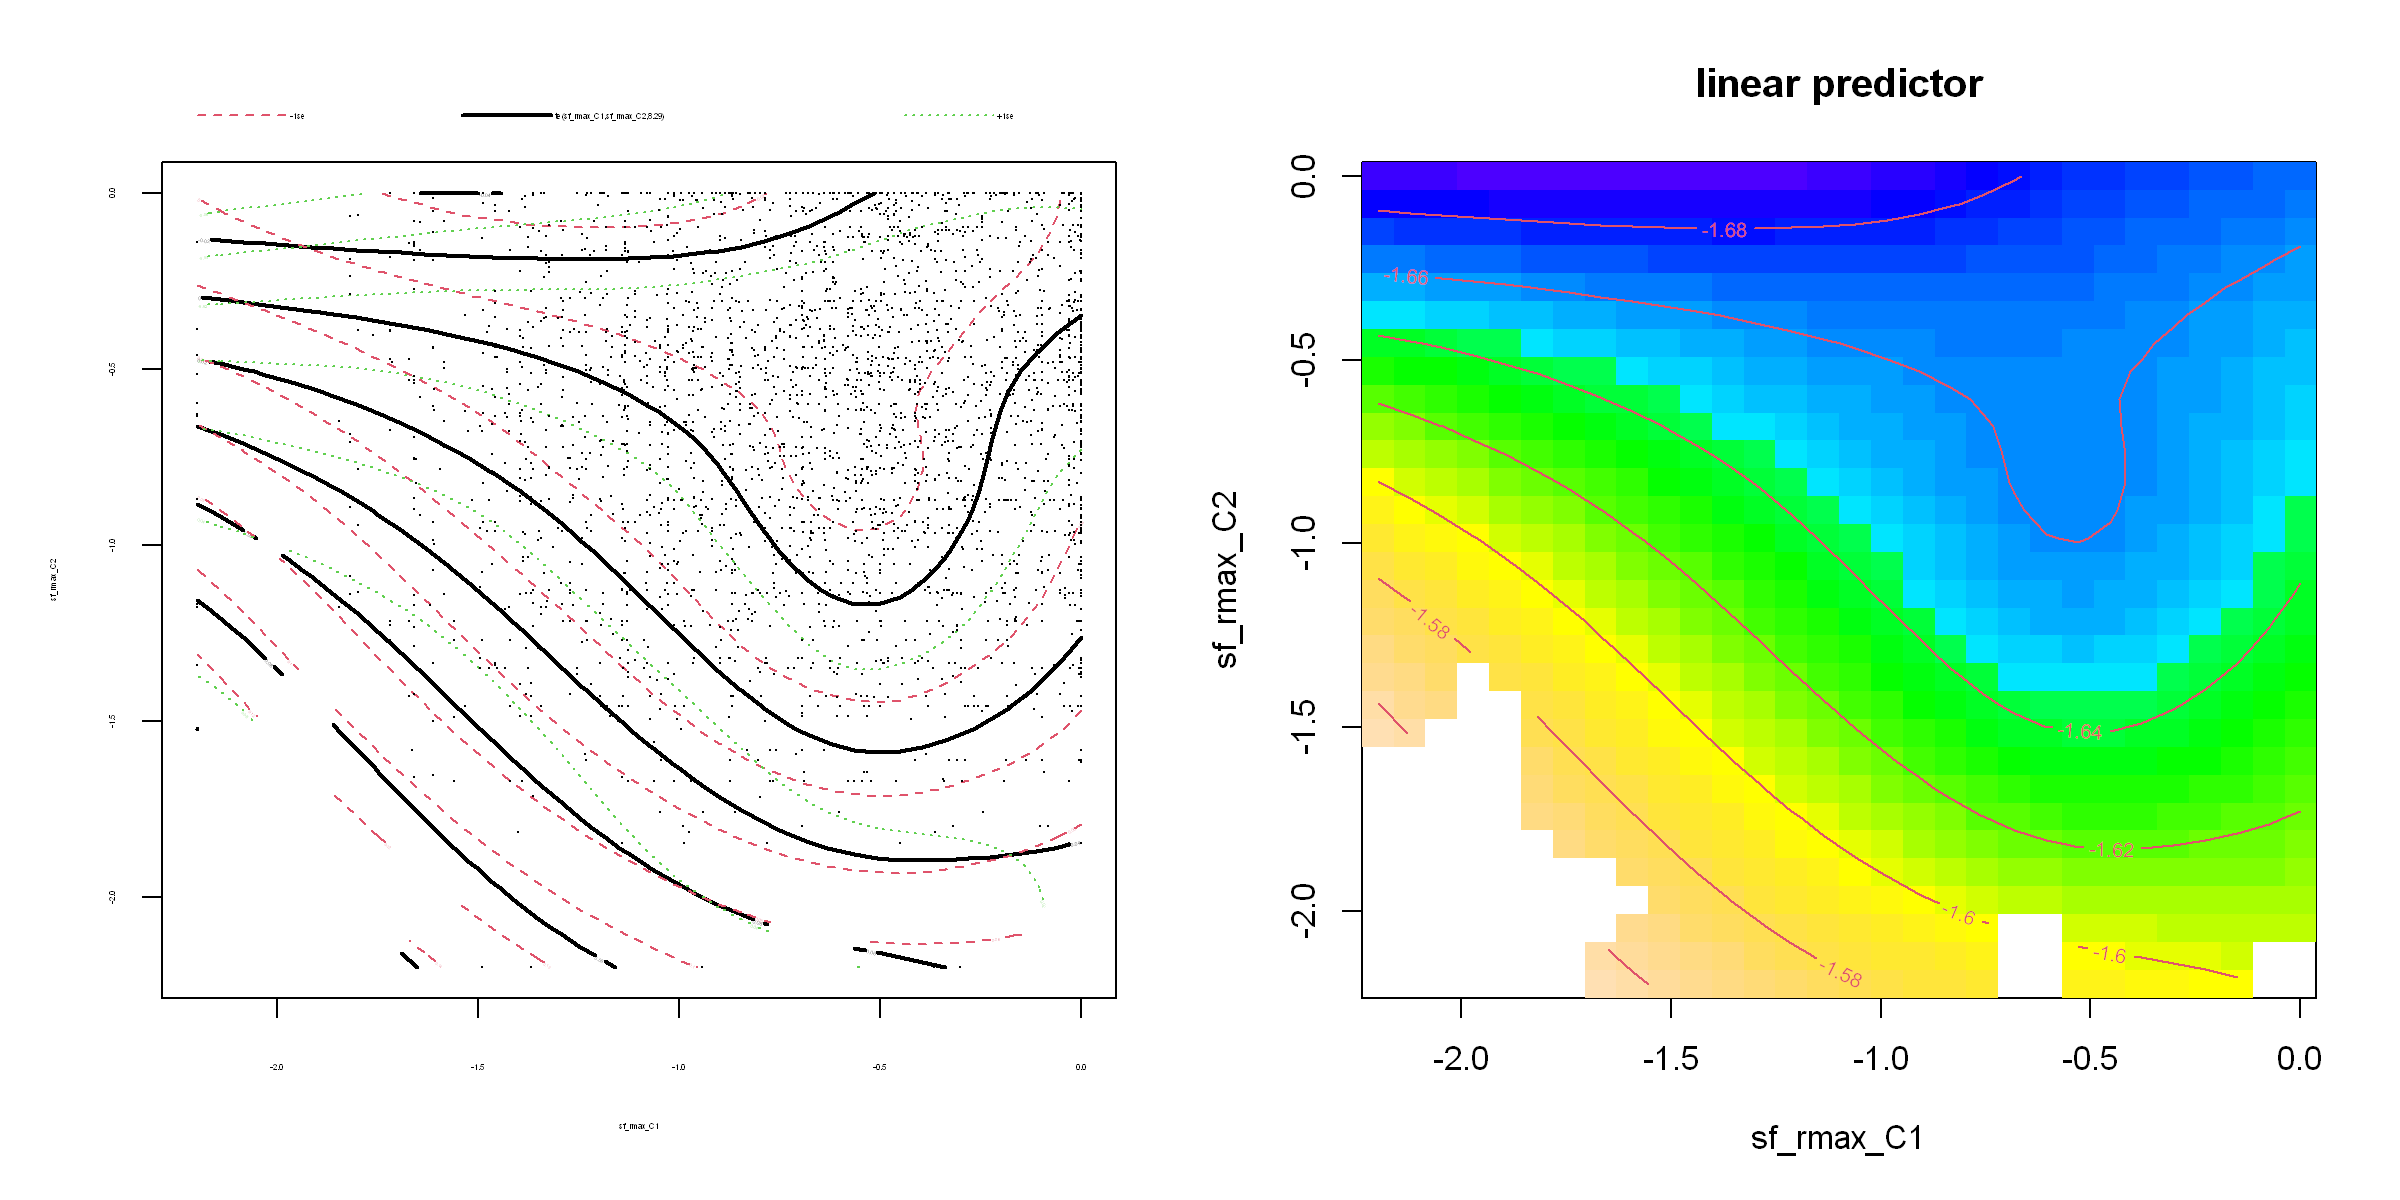

In [66]:
popt(8, 4, 200)
plot_int(m.31, 6, "sf_rmax_C1", "sf_rmax_C2")

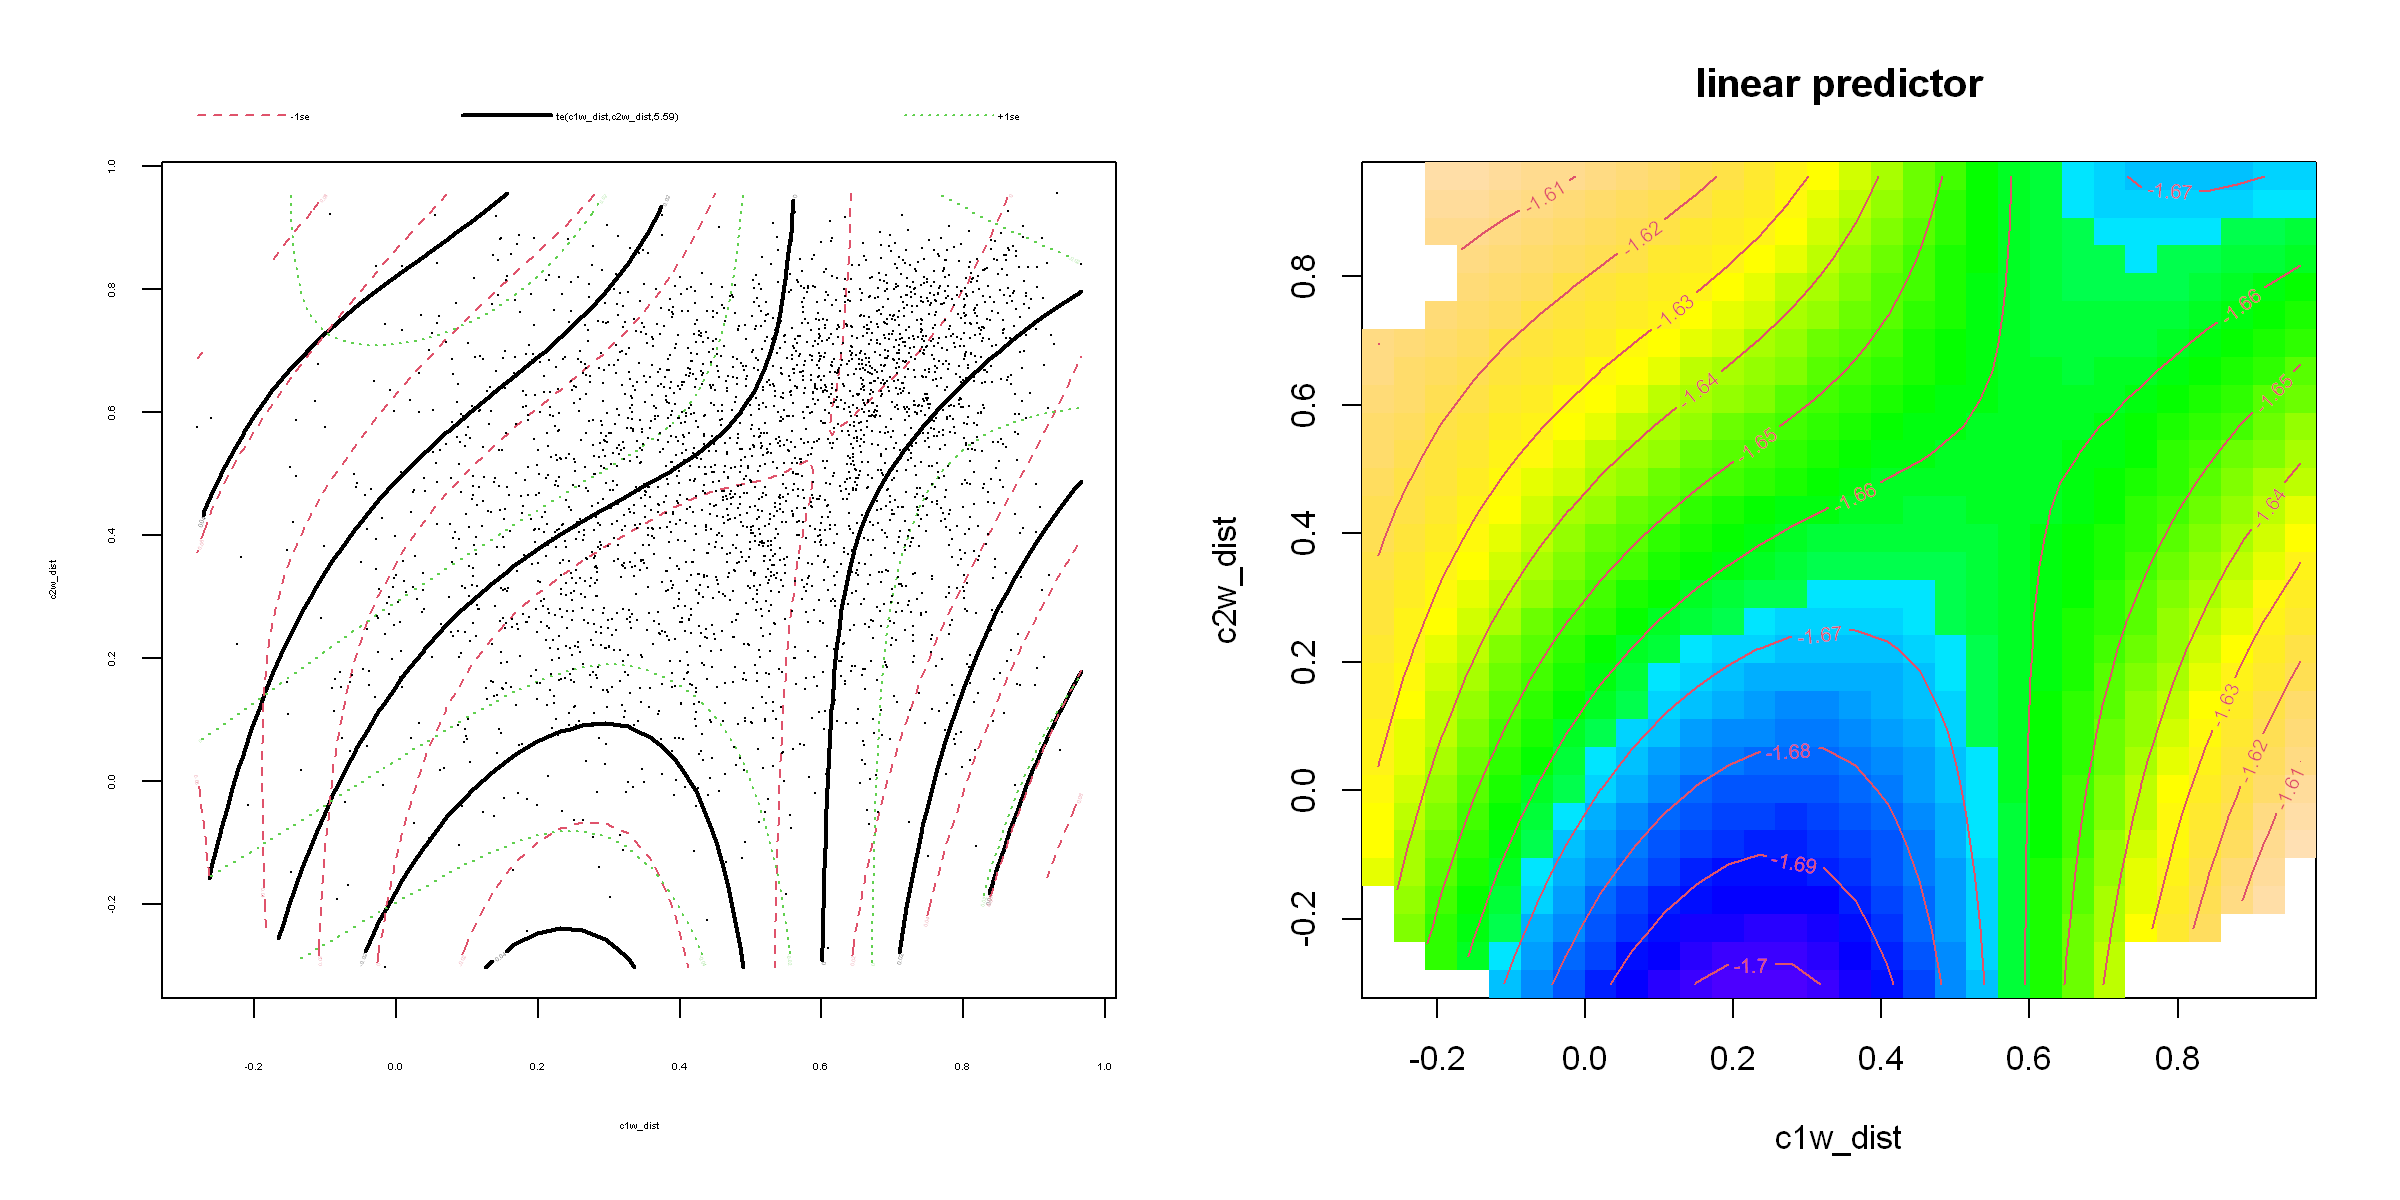

In [67]:
popt(8, 4, 200)
plot_int(m.31, 7, "c1w_dist", "c2w_dist")